# Introduction
When we talk about tabular data we mean any data that can be put in a table. The table will have rows and columns. Each row shows an instance of data (aka data point) and each column is a feature of the data. Usually at least one of the columns would be the target value. If the target is a continuous variable, then the problem is a regression, and if it is a discrete variable or categorical variable the problem is a classification.<br>
A neural network is very well suited for this type of problems, whether it is a classification or a regression problem. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn import metrics, preprocessing

# Classification
Let's start we a classification problem. In this case we will be using well log data to determine the lithology.

In [2]:
df = pd.read_parquet(
    "../../data/processed/geolink_norge_dataset/geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df.head()

LITHOLOGY_GEOLINK       CALI   RHOB         GR  \
Well    DEPT                                                         
15_9-12 2215.917725        Shaly Silt  14.438001  2.363  60.285748   
        2216.070068        Shaly Silt  14.633000  2.340  63.250000   
        2216.222412        Shaly Silt  14.813001  2.314  61.405998   
        2216.375000        Shaly Silt  14.383001  2.293  62.561596   
        2216.527344        Shaly Silt  14.202999  2.275  61.691055   

                            DTC      RDEP      RMED  
Well    DEPT                                         
15_9-12 2215.917725  134.253601  0.737006  0.785088  
        2216.070068  129.101868  0.741000  0.840000  
        2216.222412  122.476944  0.752000  0.858000  
        2216.375000  116.908607  0.739962  0.857046  
        2216.527344  115.390953  0.715966  0.886082

Let's get a list of wells:

In [3]:
wells = np.unique(np.array([w for w, d in df.index]))

And add depth as a feature column:

In [4]:
depths = np.array([d for w, d in df.index])
df["Depths"] = depths

We need to create a training and test set.

In [5]:
len(wells)

160

We can specify how many wells are used for training and how many for test. we are splitting training and test set based on the wells since there is correlation between datapoints in each well which will result in higher accuracy. But this high accuracy is deceiving and not real. As soon as we start testing the model on a new well the accuracy will drop. Splitting data based on wells avoid this issue.

In [6]:
np.random.seed(12)
n_wells = 40
selected_wells = np.random.choice(wells, n_wells * 2, replace=False)
training_wells = selected_wells[:n_wells]
test_wells = selected_wells[n_wells:]

We need to process the input and target data. The input data needs to be normalised with a standard scaler, and the output data needs to be converted from text to numbers. To convert text to numbers we use `LabelEncoder` from Scikit Learn. <br>


In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
encoder = LabelEncoder()
encoder.fit(df["LITHOLOGY_GEOLINK"])

LabelEncoder()

We also need to decide which columns from the data we are going to use as feature.

In [8]:
feat_cols = ["CALI", "RHOB", "GR", "DTC", "RDEP", "RMED", "Depths"]

`LabelEncoder` converts each type to a value. It is like creating a list of types and instead of using the names we use the their index in the list. 

In [9]:
encoder.transform(["Shaly Silt"])

array([17], dtype=int64)

Let's check the types at various depths:

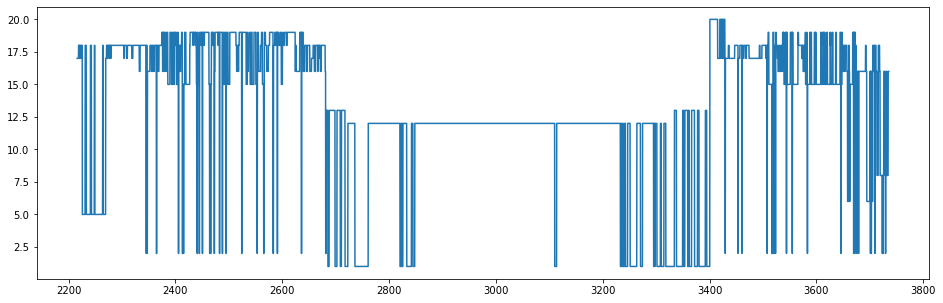

In [10]:
plt.figure(figsize=(16, 5))
idx = 0
x = df.loc[wells[idx], "Depths"]
y = encoder.transform(df.loc[wells[idx], "LITHOLOGY_GEOLINK"])
plt.plot(x, y)

Apply transformation to training and test set.

In [11]:
x_train = scaler.fit_transform(df.loc[training_wells, feat_cols].values)
y_train = encoder.transform(df.loc[training_wells, "LITHOLOGY_GEOLINK"])
x_test = scaler.transform(df.loc[test_wells, feat_cols].values)
y_test = encoder.transform(df.loc[test_wells, "LITHOLOGY_GEOLINK"])

The output of a classification model is a value for each type. The type with the highest value is the one the model thinks is most likely to be associated with the input data. Therefore, the output size of the model should be the number of types.<br>
Input size will be the number of features (columns) in the data.

In [12]:
input_size = len(feat_cols)
output_size = len(df["LITHOLOGY_GEOLINK"].unique())

Before we start with neural networks, let's see how would a random forest classifier would perform on this data.

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rf = RandomForestClassifier(
    200, max_depth=5, max_features="sqrt", n_jobs=-1, random_state=14
)

In [15]:
%%time
rf.fit(x_train,y_train)

Wall time: 7.52 s


RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=200,
                       n_jobs=-1, random_state=14)

In [16]:
preds = rf.predict(x_train)
metrics.accuracy_score(y_train, preds)

0.5193996107059051

In [17]:
preds = rf.predict(x_test)
metrics.accuracy_score(y_test, preds)

0.3537235726279804

So a random forest is giving us an accuracy of about 35%. Let's see if a neural network can beat that. 

## Linear Layer
A linear layer (sometimes called a fully-connected layer) is a simple matrix multiplication. Let's say we have an input data with $n$ features and we are trying to predict $m$ outputs. In this case the input of size $n$ is multiplied by a $n\times m$ matrix (called weight) and is summed with a $m\times 1$ matrix (called bias). The result of this operation would be an output of size $m$.
$$ \left( \begin{array}{cc}
x_1 & x_2 & ... & x_n \\
\end{array} \right)
%
\left( \begin{array}{cc}
w_{1,1} & w_{1,2} & ... & w_{1,m} \\
w_{2,1} & w_{2,2} & ... & w_{2,m} \\
 & \vdots\\
w_{n,1} & w_{n,2} & ... & w_{n,m}
\end{array} \right)
+
\left( \begin{array}{cc}
b_1 \\
b_2 \\
\vdots\\
b_m
\end{array} \right)
=
\left( \begin{array}{cc}
y_1 \\
y_2 \\
\vdots\\
y_m
\end{array} \right)
$$

Every time we perform this operation, it is called a linear layer. However, a simple linear layer is not enough to model complex relationship. Therefore, the output of the layers are passed through a non-linear function called _activation function_. <br>
There are many activation functions, but one of the most common ones is Rectified Linear Unit (ReLU). ReLU simply keeps the input value if it is positive and replaces it with zero if it is negative. Mathematically you can also write it as:<br>
$$ReLU(x) = max(0,x)$$


For the start, we create a network that has two linear layers separated by a ReLU activation function. It will takes $n$ inputs and turns it into $h$ values. After passing it through the activation function we turn it into $m$ values as output. You can see the details of the model below:

In [56]:
class SimpleLinear(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(SimpleLinear, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

<IPython.core.display.Javascript object>

Make sure we are using GPU if we have access to one.

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<IPython.core.display.Javascript object>

In [58]:
x_train = torch.Tensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.Tensor(x_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

<IPython.core.display.Javascript object>

In [59]:
len(x_train)

314929

<IPython.core.display.Javascript object>

We create an instance of the model. We are using 7 features, and trying to predict a value for each class in the data. Let's choose a hidden size of 100.

In [60]:
model = SimpleLinear(7, output_size, 100)

<IPython.core.display.Javascript object>

Use `ADAM` optimiser and Cross Entropy as loss function.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
loss_func = nn.CrossEntropyLoss()

Define a training loop and train the model.

In [61]:
def train_model(model, epochs=10, bs=256):
    for epoch in range(epochs):
        training_loss = []
        for i in range(0, len(x_train), bs):
            model.train()
            optimizer.zero_grad()
            preds = model(x_train[i : i + bs, :])
            loss = loss_func(preds, y_train[i : i + bs])
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            if i % 1000 == 0:
                print(f"Loss: {loss.item():.3f}", end="\r", flush=True)
        preds = model(x_test)
        loss = loss_func(preds, y_test)
        print(f"Epoch#{epoch+1} Test Loss = {loss.item():.3f}")

<IPython.core.display.Javascript object>

In [62]:
model.to(device)
train_model(model)

Epoch#1 Test Loss = 2.045
Epoch#2 Test Loss = 1.983
Epoch#3 Test Loss = 1.968
Epoch#4 Test Loss = 1.971
Epoch#5 Test Loss = 1.969
Epoch#6 Test Loss = 1.967
Epoch#7 Test Loss = 1.971
Epoch#8 Test Loss = 1.975
Epoch#9 Test Loss = 1.976
Epoch#10 Test Loss = 1.978


<IPython.core.display.Javascript object>

Understanding how good a model is based on loss value can be difficult. Let's check the accuracy of the model on training and test set so we can compare it to the random forest classifier we created earlier.

In [63]:
def accuracy(model, x, y):
    m = model.to("cpu")
    m.eval()
    preds = m(x.to("cpu")).argmax(-1)
    preds = preds.detach().numpy()
    return metrics.accuracy_score(y.to("cpu").numpy(), preds)

<IPython.core.display.Javascript object>

In [64]:
accuracy(model, x_train, y_train)

0.4196406174090033

<IPython.core.display.Javascript object>

In [65]:
accuracy(model, x_test, y_test)

0.3308120623072494

<IPython.core.display.Javascript object>

The accuracy is lower than the random forest. Note that our judgement will be based on accuracy on the test set. This shows how good the model is on the data it hasn't seen before. 

## Stacked Linear Layers
We discussed what linear layers are, and created a model with two linear layers separated with an activation function. This is called stacking and we cann do it with more than two layers. By adding more layers we create a deep model (hence deep learning) which can understand more complex relationship. However, it must be noted that making the model deeper can also make more difficult to train at times.

Let's create a new class which can have as many linear layers as we want. In the example below, we can pass in a list for the hidden sizes (intermediate sizes). If we only pass in one value, it would be similar to the last example, but if we put more than one value in the list we can create a deeper model.

In [66]:
class StackedLinear(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[10]):
        super(StackedLinear, self).__init__()
        sizes = [input_size] + hidden_sizes
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Sequential(nn.Linear(sizes[i], sizes[i + 1]), nn.ReLU()))
        layers.append(nn.Linear(sizes[-1], output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

<IPython.core.display.Javascript object>

Now, let's create an instance of the model with two hidden layers of size $50$.

In [68]:
model = StackedLinear(input_size, output_size, [50, 50]).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)

<IPython.core.display.Javascript object>

And train the model and check the accuracy.

In [69]:
train_model(model, epochs=10, bs=256)

Epoch#1 Test Loss = 2.165
Epoch#2 Test Loss = 2.044
Epoch#3 Test Loss = 1.997
Epoch#4 Test Loss = 1.955
Epoch#5 Test Loss = 1.952
Epoch#6 Test Loss = 1.920
Epoch#7 Test Loss = 1.920
Epoch#8 Test Loss = 1.922
Epoch#9 Test Loss = 1.901
Epoch#10 Test Loss = 1.909


<IPython.core.display.Javascript object>

In [70]:
accuracy(model, x_train, y_train)

0.4262738585522451

<IPython.core.display.Javascript object>

In [ ]:
accuracy(model, x_test, y_test)

Hopefully, the accuracy should be close to the random forest classifier and maybe even slightly better.

## Regularisation
Regularisation is a group of techniques used to stop the model from overfitting the training data and help the model to generalise the patterns in the data without memorising the actual values. Notice in the last example when we created an instance of optimiser we passed in a value for `weight_decay`. Weight decay is a regularisation technique which adds the sum of all the weights to the loss function. As a result, the optimiser tries to avoid large values for model weights which makes it less likely for the model to overfit.

### Exercise1
Retrain the model above by changing the weight decay value and see how it affects the accuracy.

In [18]:
# Code Here

### Dropout
Another type of regularisation in neural networks is called dropout. Dropout layer is positioned after the activation function and during the training phase it randommly zeros the output of neurons. By doing so, it forces the model to use smaller amount of information at each step and therefore the model wouldn't have too much information to overfit.<br>
Now let's recreate the model we used before but this time with dropout:

In [19]:
class StackedLinearDO(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[10], dropout=0.5):
        super(StackedLinearDO, self).__init__()
        sizes = [input_size] + hidden_sizes
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(
                nn.Sequential(
                    nn.Linear(sizes[i], sizes[i + 1]), nn.ReLU(), nn.Dropout(p=dropout)
                )
            )
        layers.append(nn.Linear(sizes[-1], output_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

__Note:__ The value that we pass in as dropout is the probability of each neurons output is being zeroed.

Let's create the model and train it.

In [92]:
model = StackedLinearDO(input_size, output_size, [50, 50], dropout=0.2).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)

<IPython.core.display.Javascript object>

In [93]:
train_model(model, epochs=20, bs=256)

Epoch#1 Test Loss = 2.176
Epoch#2 Test Loss = 2.094
Epoch#3 Test Loss = 2.059
Epoch#4 Test Loss = 2.037
Epoch#5 Test Loss = 2.020
Epoch#6 Test Loss = 2.002
Epoch#7 Test Loss = 1.988
Epoch#8 Test Loss = 1.964
Epoch#9 Test Loss = 1.962
Epoch#10 Test Loss = 1.960
Epoch#11 Test Loss = 1.965
Epoch#12 Test Loss = 1.949
Epoch#13 Test Loss = 1.947
Epoch#14 Test Loss = 1.942
Epoch#15 Test Loss = 1.939
Epoch#16 Test Loss = 1.938
Epoch#17 Test Loss = 1.937
Epoch#18 Test Loss = 1.940
Epoch#19 Test Loss = 1.941
Epoch#20 Test Loss = 1.936


<IPython.core.display.Javascript object>

In [94]:
accuracy(model, x_train, y_train)

0.46944549406374136

<IPython.core.display.Javascript object>

In [95]:
accuracy(model, x_test, y_test)

0.3863031373695777

<IPython.core.display.Javascript object>

If we are lucky, we should be able to get a better accuracy compared to random forest.

### Exercise 2
Try changing the value of dropout and number of layers and their size and observe how they will effect the accuracy. 

In [20]:
# Code Here

# Regression
As we discussed a regression is a problem where the target is a continuous value. For a neural netwrok the classification and regression problems are almost the same. the main difference is usually in the loss function we use. While for classification Cross Entropy is a common loss, for regression we will use Mean Square Errors in the next example.

In this example we are going to use well logs dataset again. But for the sake of practice we will switch the target from the lithology to one of the measurements, in this case Bulk Density (RHOB).

In [107]:
df = pd.read_parquet(
    "../../data/processed/geolink_norge_dataset/geolink_norge_well_logs_train.parquet"
).set_index(["Well"])
df.tail()

,DEPT,LITHOLOGY_GEOLINK,CALI,RHOB,GR,DTC,RDEP,RMED
Well,,,,,,,,
7_3-1,4569.153320,Cross Bedded Sst,8.538,2.643616,50.886002,63.442799,6.727,6.835000
7_3-1,4569.305664,Cross Bedded Sst,8.540,2.631049,51.219002,63.450794,6.639,6.690000
7_3-1,4569.458008,Cross Bedded Sst,8.548,2.626054,51.671001,63.590557,6.551,6.520000
7_3-1,4569.610352,Cross Bedded Sst,8.552,2.624065,51.820999,64.036644,6.464,6.462185
7_3-1,4569.762695,Cross Bedded Sst,8.546,2.636137,51.327999,64.322495,6.423,6.439074


<IPython.core.display.Javascript object>

We still need to go through the same preprocessing steps as before.

In [108]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
scaler_rho = StandardScaler()
encoder = LabelEncoder()
encoder.fit(df["LITHOLOGY_GEOLINK"])

<IPython.core.display.Javascript object>

In [132]:
feat_cols = ["CALI", "GR", "DTC", "RDEP", "RMED", "DEPT"]

<IPython.core.display.Javascript object>

In this example now we face an interesting problem. We have categorical values as input. Note that neural networks are a series of mathematical operations; therefore cannot deal with non-numerical variables.<br>
But actually we converted the classes into values using a label encoder, so we should be alright? The problem with using the encoder output is that they are indices not values. They don't have mathematical significance. When index of one type is $4$ and the other is $2$, it doesn't mean some characteristics of the first type has twice the value of the second. We need a better way of dealing with categorical values. One common method is One Hot Encoding. One hot encoding adds a column to features for each type. The value of one of the columns will be one depending on the type.<br>
Let's understand this through an example. Let's say the data has feature that only has three types __A__, __B__, and __C__. By one hot encoding we replace the column with three columns. Each column will contain either one or zero. 
- The first column would be one if the type is __A__ otherwise zero.
- The second column would be one if the type is __B__ otherwise zero.
- The third column would be one if the type is __C__ otherwise zero.

Therefore, if the type was A, the value for the one hot encoded columns would be 1, 0, and , 0.<br>
This method despite being useful, has some drawbacks. One issue is that when you have multiple classes you need to add many columns to data which makes processing more difficult.

### Feature Embedding
The flexibility of neural networks allows us to use a technique much better that one hot encoding. This method is called feature embedding. In this method we create a table which assigns a number of features to each class. Then, when the data is passed through the network, instead of the categorical variables their features from the embedding table will be used. What is intersting about this method is that we do not know the values in the table when we start the training process. They will be learned during the training. 

Since we have one categorical variable, and the rest are numerical, we can separate the inputs into a categorical inputs and numerical inputs.

In [166]:
xnum_train = scaler.fit_transform(df.loc[training_wells, feat_cols].values)
xcat_train = encoder.transform(df.loc[training_wells, "LITHOLOGY_GEOLINK"])
y_train = scaler_rho.fit_transform(df.loc[training_wells, ["RHOB"]].values)

xnum_test = scaler.transform(df.loc[test_wells, feat_cols].values)
xcat_test = encoder.transform(df.loc[test_wells, "LITHOLOGY_GEOLINK"])
y_test = scaler_rho.transform(df.loc[test_wells, ["RHOB"]].values)

<IPython.core.display.Javascript object>

The we need to create a new model with embedding tables for categorical variables. We need to specify how many types there are in our categorical columns (num_classes), and how many values will be used to represent each type (emb_vec_size). Then, in the model we create a stacked linear layers with dropout (as defined before) using the right number of inputs (numerical inputs + embedding features).

In [167]:
class FeatureEmbed(nn.Module):
    def __init__(self, hidden_sizes, num_classes, emb_vec_size, dropout=0.5):
        super(FeatureEmbed, self).__init__()
        self.emb = nn.Embedding(num_classes, emb_vec_size)
        self.net = StackedLinearDO(
            input_size=6 + emb_vec_size,
            output_size=1,
            hidden_sizes=hidden_sizes,
            dropout=dropout,
        )

    def forward(self, xnum, xcat):
        x1 = self.emb(xcat)
        x_in = torch.cat((x1, xnum), dim=1)
        return self.net(x_in)

<IPython.core.display.Javascript object>

Now, we can create an instance of the model.

In [168]:
num_classes = len(encoder.classes_)

<IPython.core.display.Javascript object>

In [169]:
vec_size = 2
dropout = 0.3
model = FeatureEmbed(
    hidden_sizes=[50, 50],
    num_classes=num_classes,
    emb_vec_size=vec_size,
    dropout=dropout,
).to(device)

<IPython.core.display.Javascript object>

In [170]:
xnum_train = torch.Tensor(xnum_train).to(device)
xcat_train = torch.LongTensor(xcat_train).to(device)
y_train = torch.Tensor(y_train).to(device)

xnum_test = torch.Tensor(xnum_test).to(device)
xcat_test = torch.LongTensor(xcat_test).to(device)
y_test = torch.Tensor(y_test).to(device)

<IPython.core.display.Javascript object>

Use Mean Square Error as loss function.

In [171]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

<IPython.core.display.Javascript object>

And define a training loop. The training loop is slightly different, since we have a numerical input and a categorical input.

In [172]:
def train_emb_model(model, epochs=10, bs=256):
    for epoch in range(epochs):
        training_loss = []
        for i in range(0, len(x_train), bs):
            model.train()
            optimizer.zero_grad()
            preds = model(xnum_train[i : i + bs, :], xcat_train[i : i + bs])
            loss = loss_func(preds, y_train[i : i + bs])
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            if i % 1000 == 0:
                print(f"Loss: {loss.item():.3f}", end="\r", flush=True)
        preds = model(xnum_test, xcat_test)
        loss = loss_func(preds, y_test)
        print(f"Epoch#{epoch+1} Test Loss = {loss.item():.3f}")

<IPython.core.display.Javascript object>

In [173]:
train_emb_model(model, epochs=10, bs=256)

Epoch#1 Test Loss = 0.764
Epoch#2 Test Loss = 0.637
Epoch#3 Test Loss = 0.642
Epoch#4 Test Loss = 0.608
Epoch#5 Test Loss = 0.589
Epoch#6 Test Loss = 0.576
Epoch#7 Test Loss = 0.570
Epoch#8 Test Loss = 0.560
Epoch#9 Test Loss = 0.560
Epoch#10 Test Loss = 0.547


<IPython.core.display.Javascript object>

We can use $R^2$ as metric.

In [174]:
def Rsquare(model, xnum, xcat, y):
    m = model.to("cpu")
    m.eval()
    preds = m(xnum.to("cpu"), xcat.to("cpu"))
    preds = preds.detach().numpy()
    return metrics.r2_score(y.to("cpu").numpy(), preds)

<IPython.core.display.Javascript object>

In [175]:
Rsquare(model, xnum_train, xcat_train, y_train)

0.5742407707306343

<IPython.core.display.Javascript object>

In [176]:
Rsquare(model, xnum_test, xcat_test, y_test)

0.5727409324173567

<IPython.core.display.Javascript object>

The model is trained, which means we should be able to have a look at embedding table and see the values in there.

In [180]:
embed = model.emb.weight.detach().numpy()

<IPython.core.display.Javascript object>

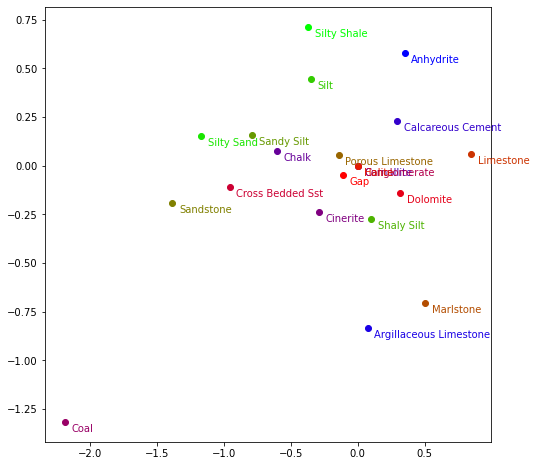

<IPython.core.display.Javascript object>

In [233]:
from matplotlib import cm

cmap = cm.get_cmap("brg", num_classes)
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    x = embed[i, 0]
    y = embed[i, 1]
    color = cmap(i)
    litho = encoder.inverse_transform([i])
    plt.scatter(x, y, color=color)
    plt.text(x + 0.05, y - 0.05, litho[0], color=color)

The plot above shows the two values we used for each type. If the model is trained well, we should be able to see types with closer characteristics should be placed closer to each other in the plot above. This is another interesting feature of embedding tables. It allows us to not only to convert categorical variables to numericals, but also we can see the behaviour of each class and compare them together.

### Exercise
Try increasing the number of embedding features to $5$ and see how it would affect $R^2$ value.

In [ ]:
# Code Here


<div class="alert alert-success">
    
### Solutions  
<details><summary>See solutions</summary>

<details><summary>Exercise 1</summary>
<b>No weight decay</b>

```Python
model = StackedLinear(input_size, output_size, [50, 50]).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0)
train_model(model, epochs=10, bs=256)
accuracy(model, x_test, y_test)
```
<b>Large weight decay</b>
```Python
model = StackedLinear(input_size, output_size, [50, 50]).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.1)
train_model(model, epochs=10, bs=256)
accuracy(model, x_test, y_test)
```

</details>
<details><summary>Exercise 2</summary>
    <b>Larger dropout</b>
    
```Python
model = StackedLinearDO(input_size, output_size, [50, 50], dropout=0.6).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)
train_model(model, epochs=20, bs=256)
accuracy(model, x_test, y_test)
```

    <b>More layers</b>
    
```Python
model = StackedLinearDO(input_size, output_size, [50, 50, 50], dropout=0.2).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)
train_model(model, epochs=20, bs=256)
accuracy(model, x_test, y_test)
```
    
    <b>Larger Layers</b>
    
```Python
model = StackedLinearDO(input_size, output_size, [100, 100], dropout=0.2).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)
train_model(model, epochs=20, bs=256)
accuracy(model, x_test, y_test)
```
    
</details>
<details><summary>Exercise 3</summary>

```Python
vec_size = 5
dropout = 0.3
model = FeatureEmbed(
    hidden_sizes=[50, 50],
    num_classes=num_classes,
    emb_vec_size=vec_size,
    dropout=dropout,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train_emb_model(model, epochs=10, bs=256)
Rsquare(model, xnum_test, xcat_test, y_test)
```

</details>
</details>
</div>

# Further Reading
- [Regularisation](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)
- [Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5#:~:text=According%20to%20Wikipedia%20%E2%80%94,which%20is%20chosen%20at%20random.)
- [Why One-Hot Encode Data in Machine Learning?](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)
- [Neural Network Embeddings Explained](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526)